# Wiener SVD MC closure test using 1mu 1p selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
from wienersvd import *

import pandas_helpers as ph

import dunestyle.matplotlib as dunestyle

DUNE plot style enabled


In [2]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

In [3]:
def InFV(data): # cm
    xmin = -190.
    ymin = -190.
    zmin = 10.
    xmax = 190.
    ymax =  190.
    zmax =  450.
    return (np.abs(data.x) > 10) & (np.abs(data.x) < 190) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

In [4]:
def get_n_split(file):
    this_split_df = pd.read_hdf(file, key="split")
    this_n_split = this_split_df.n_split.iloc[0]
    return this_n_split

def print_keys(file):
    with pd.HDFStore(file, mode='r') as store:
        keys = store.keys()       # list of all keys in the file
        print("Keys:", keys)

## Opening an MC data frame
This data frame is produced using gump.py configuration

In [5]:
## -- MC study
mc_file = "/data/sungbino/sbnd/v10_06_00_02/mc_MCP2025B_5e18_02_prodgenie_corsika_proton_rockbox_sbnd_CV_caf_flat_caf_sbnd_gump.df"
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_n_split: 6
Keys: ['/evt_0', '/evt_1', '/evt_2', '/evt_3', '/evt_4', '/evt_5', '/hdr_0', '/hdr_1', '/hdr_2', '/hdr_3', '/hdr_4', '/hdr_5', '/mcnu_0', '/mcnu_1', '/mcnu_2', '/mcnu_3', '/mcnu_4', '/mcnu_5', '/split']


In [6]:
n_max_concat = 2

In [7]:
def load_dfs(file, keys2load):
    out_df_dict = {}
    this_n_keys = get_n_split(file)
    n_concat = min(n_max_concat, this_n_keys)
    for key in keys2load:
        dfs = []  # collect all splits for this key
        for i in range(n_concat):
            this_df = pd.read_hdf(file, key=f"{key}_{i}")
            dfs.append(this_df)
        out_df_dict[key] = pd.concat(dfs, ignore_index=False)

    return out_df_dict

In [8]:
mc_keys2load = ['evt', 'hdr', 'mcnu']
mc_dfs = load_dfs(mc_file, mc_keys2load)

In [9]:
mc_evt_df = mc_dfs['evt']
mc_hdr_df = mc_dfs['hdr']
mc_nu_df = mc_dfs['mcnu']

In [10]:
## total pot
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))

target_pot = 1e20
mc_pot_scale = target_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_pot_scale = 1.

mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

mc_tot_pot: 5.007e+18
mc_pot_scale: 1.997e+01


## Event Selections

In [11]:
twoprong_cut = (np.isnan(mc_evt_df.other_shw_length) & np.isnan(mc_evt_df.other_trk_length))
mc_evt_df = mc_evt_df[twoprong_cut]

In [12]:
mc_evt_df["truth_totp"] = np.sqrt(mc_evt_df.mu.pfp.trk.truth.p.genp.x**2 + mc_evt_df.mu.pfp.trk.truth.p.genp.y**2 + mc_evt_df.mu.pfp.trk.truth.p.genp.z**2)


/tmp/ipykernel_3492898/515027472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_evt_df["truth_totp"] = np.sqrt(mc_evt_df.mu.pfp.trk.truth.p.genp.x**2 + mc_evt_df.mu.pfp.trk.truth.p.genp.y**2 + mc_evt_df.mu.pfp.trk.truth.p.genp.z**2)


In [13]:
def Signal(df): # definition                                                                                                                                                                                                                                                                         
    is_fv = InFV(df.position)
    is_1pi1p = (df.nmu_27MeV == 1) & (df.npi_30MeV == 0) & (df.np_50MeV == 1) & (df.np_20MeV == 1) & (df.npi0 == 0) & (df.mu.genE > 0.25)
    return is_fv & is_1pi1p

Truth level evt categories

In [14]:
is_fv = InFV(mc_nu_df.position)
is_signal = Signal(mc_nu_df)

nuint_categ = pd.Series(8, index=mc_nu_df.index)

nuint_categ[~is_fv] = -1 #out of FV
nuint_categ[is_fv & is_signal] = 1 #signal
nuint_categ[is_fv & ~is_signal] = 2 #other

mc_nu_df['nuint_categ'] = nuint_categ

In [15]:
mc_nu_df['nuint_categ'] = nuint_categ

In [16]:
mc_nu_df['truth_totp'] = np.sqrt(mc_nu_df.mu.genp.x**2 + mc_nu_df.mu.genp.y**2 + mc_nu_df.mu.genp.z**2)

Matching between reco. and true nu-interaction data frames

In [17]:
mc_nu_df.columns = pd.MultiIndex.from_tuples([('gen',) + col if isinstance(col, tuple) else ('gen', col) for col in mc_nu_df.columns])
mc_nu_df.columns = pd.MultiIndex.from_tuples([
    col + ('',) * (8 - len(col)) for col in mc_dfs["mcnu"].columns
])

mc_evt_df = ph.multicol_merge(mc_evt_df.reset_index(), mc_nu_df.reset_index(),
                                left_on=[('__ntuple', '', '', '', '', '', '', ''), ('entry', '', '', '', '', '', '', ''), ('slc','tmatch', 'idx', '', '', '', '', '')],
                                right_on=[('__ntuple', '', '', '', '', '', '', ''), ('entry', '', '', '', '', '', '', ''), ('rec.mc.nu..index', '','', '', '', '', '', '')], 
                                how="left") ## -- save all sllices

mc_evt_df.loc[mc_evt_df[('gen', 'nuint_categ', '', '', '', '', '', '')].isna(), [('gen', 'nuint_categ', '', '', '', '', '', '')]] = -2

In [18]:
mc_evt_df.gen.nuint_categ.value_counts()

nuint_categ
-2.0    7790
 1.0    6034
 2.0    4172
-1.0    2779
Name: count, dtype: int64

## Make Spectrum for MC and Fake data

An example binning for muon momentum

In [19]:
var_label = r"$\mathrm{P_\mu~[GeV/c]}$"
var_label_reco = r"$\mathrm{P_\mu^{reco.}~[GeV/c]}$"
var_label_true = r"$\mathrm{P_\mu^{true}~[GeV/c]}$"

bins = np.linspace(0.2, 2, 6)

Definitions for plotting:
IMPORTANT NOTE: putting signal as the first element for convenience later

In [20]:
mode_list = [1, 2, -1, -2]
mode_labels = ["Signal", "Non-sig. FV Nuint", "Non FV", "Others"] #, "Intime Cosmics"]
colors = ['#d62728',  # Red            
          '#1f77b4',  # Blue
          '#ff7f0e',
          '#7f7f7f']  # Gray

np.clip is for including underflow events into the first bin and overflow evetns into the last bin

In [21]:
# Total MC reco muon momentum: for fake data
var_col = ('mu', 'pfp', 'trk', 'P', 'p_muon', '', '', '')
eps = 1e-8
var_total_mc = mc_evt_df.mu.pfp.trk.P.p_muon
var_total_mc = np.clip(var_total_mc, bins[0], bins[-1] - eps)

# mc_evt_df divided into mode for subtraction from data in futre
mc_evt_df_divided = [mc_evt_df[mc_evt_df.gen.nuint_categ == mode]for mode in mode_list]

# Reco muon momentum for each 'nuint_categ' for stack plot and subtraction from the fake data
var_per_nuint_categ_mc = [mc_evt_df[mc_evt_df.gen.nuint_categ == mode][var_col]for mode in mode_list]
var_per_nuint_categ_mc = [s.clip(bins[0], bins[-1] - eps) for s in var_per_nuint_categ_mc]
weights_per_categ = [mc_evt_df.loc[mc_evt_df.gen.nuint_categ == mode, 'pot_weight'] for mode in mode_list]

# Signal event's reco muon momentum: for response matrix
var_signal = mc_evt_df[mc_evt_df.gen.nuint_categ == 1].mu.pfp.trk.P.p_muon
var_signal = np.clip(var_signal, bins[0], bins[-1] - eps)
weight_signal = mc_evt_df.loc[mc_evt_df.gen.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum after the event selection: for response matrix
true_var_signal_sel = mc_evt_df[mc_evt_df.gen.nuint_categ == 1].truth_totp
true_var_signal_sel = np.clip(true_var_signal_sel, bins[0], bins[-1] - eps)
weight_true_signal = mc_evt_df.loc[mc_evt_df.gen.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum without event selection: for efficiency vector
var_truth_signal = mc_nu_df[mc_nu_df.gen.nuint_categ == 1].gen.truth_totp
var_truth_signal = np.clip(var_truth_signal, bins[0], bins[-1] - eps)
weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

Draw true (before event selection) and reco (after event selection) muon momentum distributions of signal events.
Print entries for double check.

[4011. 2491.  904.  295.  230.]
[3042. 1802.  725.  266.  199.]
[2828. 1930.  857.  258.  161.]


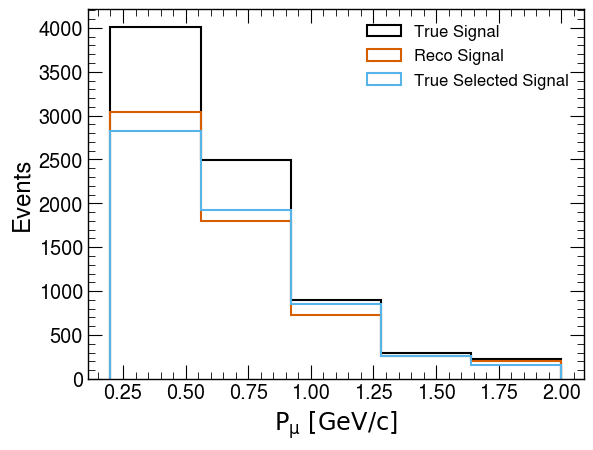

In [22]:
true_signal, _, _ = plt.hist(var_truth_signal, bins=bins, weights=weight_truth_signal, histtype="step", label="True Signal")
reco_signal, _, _ = plt.hist(var_signal, bins=bins, weights=weight_signal, histtype="step", label="Reco Signal")
true_signel_sel, _, _ = plt.hist(true_var_signal_sel, bins=bins, weights=weight_signal, histtype="step", label="True Selected Signal")
print(true_signal)
print(reco_signal)
print(true_signel_sel)
plt.legend()
plt.ylabel("Events")
plt.xlabel(var_label)
plt.show()

## Overlayed spectrum

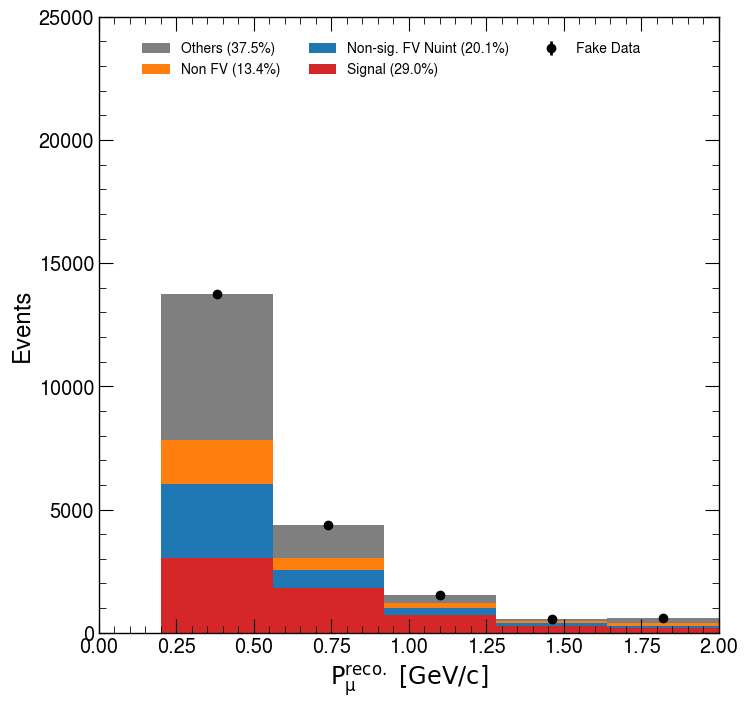

In [23]:
plt.figure(figsize=(8, 8))
mc_stack, bins, _ = plt.hist(var_per_nuint_categ_mc,
                            bins=bins,
                            weights=weights_per_categ,
                            stacked=True,
                            color=colors,
                            label=mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=bins, weights=mc_evt_df.pot_weight)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fake_data = totmc
fake_data_err = np.sqrt(totmc)
#plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data")
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.ylim(0., 25000.)
plt.xlim(0.0, 2)
plt.ylabel("Events")
plt.xlabel(var_label_reco)

plt.show()

# Response

In [24]:
## A function is to make text in 2D plots more visible
def get_text_color(value):
    rgba = cmap(norm(value))
    # Compute luminance (perceived brightness)
    luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    return "black" if luminance > 0.5 else "white"

def bin_range_labels(edges):
    return [f"{edges[i]:.2f}–{edges[i+1]:.2f}" for i in range(len(edges)-1)]

For selected signal, true vs. reco. muon momentum

[[2549.  228.   24.   10.   17.]
 [ 278. 1398.  203.   28.   23.]
 [ 177.  142.  403.  103.   32.]
 [  34.   14.   67.   98.   45.]
 [   4.   20.   28.   27.   82.]]


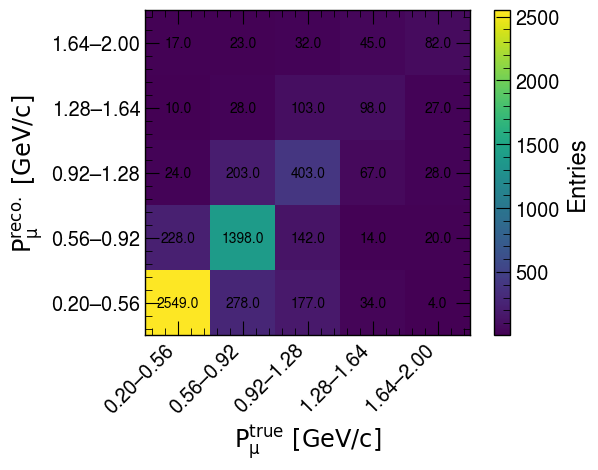

In [25]:
bins_2d = bins# = [np.array([0.2, 2]), np.array([0.2, 2])] # commented out lines for 1 bin MC closure test
reco_vs_true, bins, _ = np.histogram2d(true_var_signal_sel, var_signal, bins=bins_2d)
Response = reco_vs_true.T
print(reco_vs_true)

unif_bin = np.linspace(0., float(len(bins) - 1), len(bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]
plt.imshow(Response, extent=extent, origin="lower", cmap="viridis")
plt.colorbar(label="Entries")

x_edges = np.array(bins)
y_edges = np.array(bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)

plt.xlabel(var_label_true)
plt.ylabel(var_label_reco)

for i in range(Response.shape[0]):      # rows (y)
    for j in range(Response.shape[1]):  # columns (x)
        value = Response[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.1f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )

plt.tight_layout()
plt.show()

Effieincy vector

In [26]:
reco_vs_true.T.sum(axis=0)

array([2828., 1930.,  857.,  258.,  161.])

In [27]:
true_signal

array([4011., 2491.,  904.,  295.,  230.])

In [28]:
eff = reco_vs_true.T.sum(axis=0) / true_signal  # efficiency per truth bin
print("eff")
print(eff)

eff
[0.70506108 0.77478924 0.94800885 0.87457627 0.7       ]


Response matrix for Wiener SVD is actually Response X Eff.

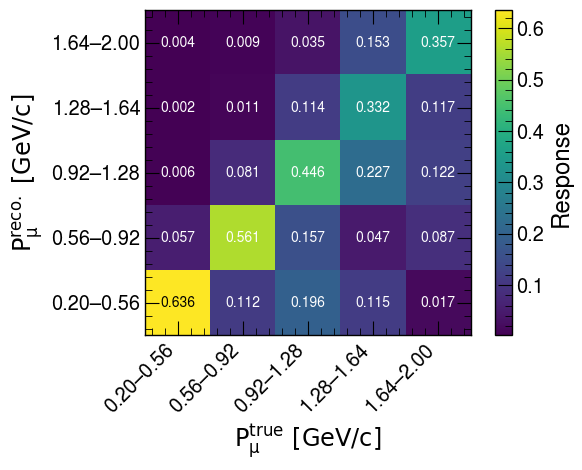

In [29]:
denom = reco_vs_true.T.sum(axis=0)
num = reco_vs_true.T
Response = np.divide(
    num * eff, denom,
    out=np.zeros_like(num, dtype=float),  # fill with 0 where invalid
    where=denom != 0
)

unif_bin = np.linspace(0., float(len(bins) - 1), len(bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]
plt.imshow(Response, extent=extent, origin="lower", cmap="viridis")
plt.colorbar(label="Response")

x_edges = np.array(bins)
y_edges = np.array(bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)

plt.xlabel(var_label_true)
plt.ylabel(var_label_reco)

for i in range(Response.shape[0]):      # rows (y)
    for j in range(Response.shape[1]):  # columns (x)
        value = Response[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.3f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )

plt.tight_layout()
plt.show()

# Covariance

Considered multiverses

In [30]:
# flux
flux_systs = [
    'expskin_Flux',
    'horncurrent_Flux',
    'kminus_Flux',
    'kplus_Flux',
    'kzero_Flux',
    'nucleoninexsec_Flux',
    'nucleonqexsec_Flux',
    'nucleontotxsec_Flux',
    'piminus_Flux',
    'pioninexsec_Flux',
    'pionqexsec_Flux',
    'piontotxsec_Flux',
    'piplus_Flux'
]

Produce "Fake data - bkg" distributions in multiverses

In [31]:
var_total_mc
fake_data, bins, _ = plt.hist(var_total_mc, bins=bins,histtype="step", color="gray")
plt.close()
fake_data

array([13751.,  4363.,  1517.,   556.,   588.])

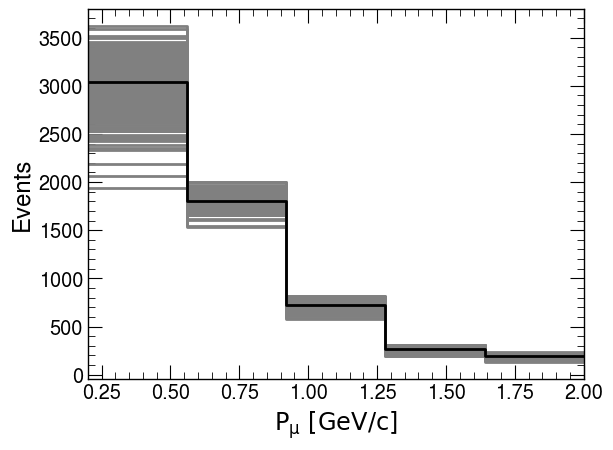

In [32]:
bin_centers = (bins[:-1] + bins[1:])/2
univ_events = []
nominal_event = fake_data
for this_mc_evt_df in mc_evt_df_divided[1:]:
    this_var = this_mc_evt_df.mu.pfp.trk.P.p_muon
    this_var = np.clip(this_var, bins[0], bins[-1] - eps)
    this_n, bins, _ = plt.hist(this_var, bins=bins, histtype="step", color="gray")
    nominal_event = nominal_event - this_n

for uidx in range(250):
    this_signal = fake_data # before subtraction
    for this_mc_evt_df in mc_evt_df_divided[1:]:
        weights = np.ones(len(this_mc_evt_df))
        for flux_syst in flux_systs:
            this_weights = this_mc_evt_df[("gen", flux_syst, "univ_"+str(uidx), '', '', '', '', '')].copy()
            this_weights[np.isnan(weights)] = 1
            weights *= this_weights
        weights[np.isnan(weights)] = 1 ## IMPORTANT: make nan weights to 1. to ignore them
        this_var = this_mc_evt_df.mu.pfp.trk.P.p_muon
        this_var = np.clip(this_var, bins[0], bins[-1] - eps)
        this_n, bins, _ = plt.hist(this_var, bins=bins, weights=weights, histtype="step", color="gray")
        plt.close()
        this_signal = this_signal - this_n # a subtracted hitogram for a multiverse
    univ_events.append(this_signal)

for univ_event in univ_events:
    plt.step(bin_edges, np.append(univ_event, univ_event[-1]), where='post', label='Unfolded', color="gray")
    plt.xlim(bins[0], bins[-1])
    plt.xlabel(var_label)
    plt.ylabel("Events")

plt.step(bin_edges, np.append(nominal_event, nominal_event[-1]), where='post', label='Unfolded', color="black")


Make covariance matrix out of the above distributions

[[77051.14222615 20929.50855031  9964.66103212  4779.88764247
   3935.07485812]
 [20929.50855031  6124.62456081  3050.8449122   1488.6918207
   1190.55614672]
 [ 9964.66103212  3050.8449122   1661.30221455   846.04119609
    653.53768405]
 [ 4779.88764247  1488.6918207    846.04119609   451.36448335
    334.33873146]
 [ 3935.07485812  1190.55614672   653.53768405   334.33873146
    272.32868834]]


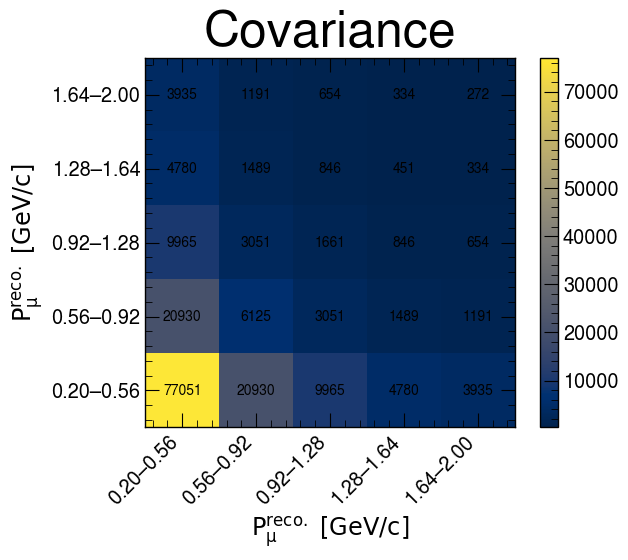

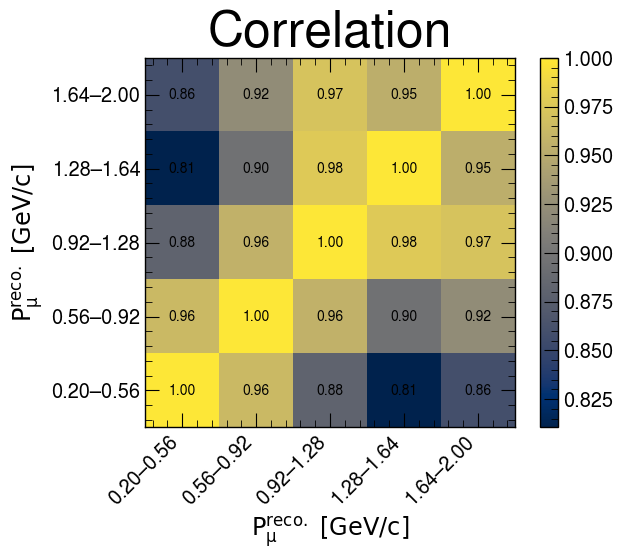

In [33]:
univ_events = np.array(univ_events)
Covariance = np.cov(univ_events, rowvar=False)
Covariance = np.atleast_2d(Covariance)
print(Covariance)
plt.imshow(Covariance, extent=extent, origin="lower")
plt.colorbar()
plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)
plt.xlabel(var_label_reco)
plt.ylabel(var_label_reco)
for i in range(Covariance.shape[0]):      # rows (y)
    for j in range(Covariance.shape[1]):  # columns (x)
        value = Covariance[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.0f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )
plt.title("Covariance")
plt.savefig("./plots/wiener_svd/1mu1p/cov.pdf")
plt.show();

corr = np.corrcoef(univ_events.T)
corr = np.atleast_2d(corr)
plt.imshow(corr, extent=extent, origin="lower")
plt.colorbar()
plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)
plt.xlabel(var_label_reco)
plt.ylabel(var_label_reco)
for i in range(corr.shape[0]):      # rows (y)
    for j in range(corr.shape[1]):  # columns (x)
        value = corr[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.2f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )
plt.title("Correlation")
plt.show();

Singal distribution with error bars from diagonal components of covariance matrix

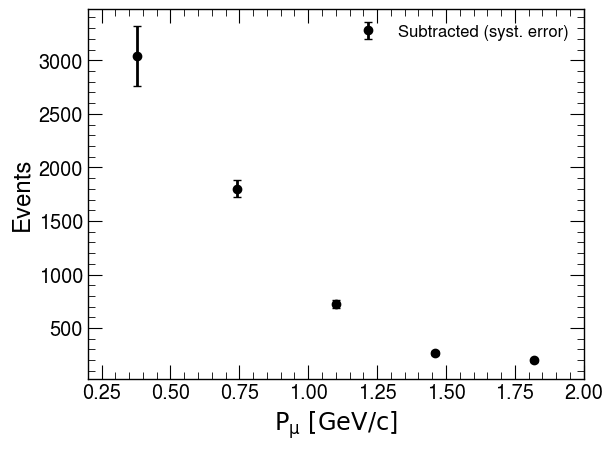

In [34]:
uncert = np.sqrt(np.diag(Covariance))

# Compute bin centers for error bars
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Add error bars
plt.errorbar(bin_centers, nominal_event, yerr=uncert, fmt='o', color='black', label='Subtracted (syst. error)', capsize=3)
plt.xlim(bins[0], bins[-1])
plt.xlabel(var_label)
plt.ylabel("Events")
plt.legend()
plt.show()

# Try Unfolding

In [35]:
nominal_event

array([3042., 1802.,  725.,  266.,  199.])

In [36]:
true_signal

array([4011., 2491.,  904.,  295.,  230.])

In [37]:
C_type = 1
Norm_type = 1
unfold = WienerSVD(Response, true_signal, nominal_event, Covariance, C_type, Norm_type)

In [38]:
unfold['unfold']

array([4006.81384647, 2490.59339627,  901.55330633,  303.86007067,
        223.96360607])

In [39]:
unfold['UnfoldCov']

array([[155236.60339544,  28382.08937084,  15902.03619603,
          8197.5481918 ,   6974.09420819],
       [ 28382.08937084,   6222.05536854,   3501.11592441,
          1833.26395684,   1497.74315432],
       [ 15902.03619603,   3501.11592441,   2298.98196909,
          1226.98776872,   1002.78151577],
       [  8197.5481918 ,   1833.26395684,   1226.98776872,
           796.1795204 ,    564.94132215],
       [  6974.09420819,   1497.74315432,   1002.78151577,
           564.94132215,    538.95966654]])

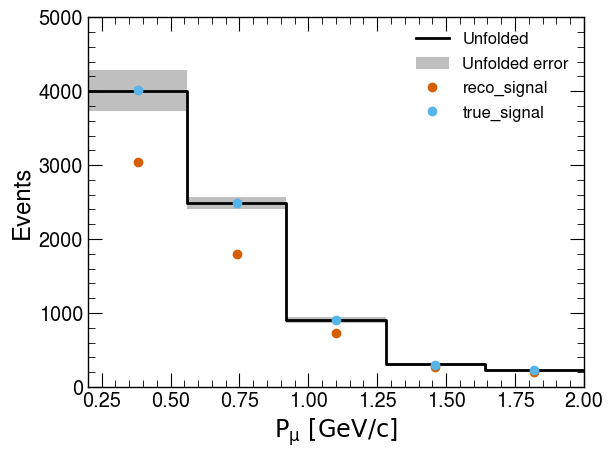

In [40]:
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
Unfold_uncert = np.sqrt(np.diag(Covariance))

step_handle, = plt.step(bin_edges, np.append(Unfold, Unfold[-1]), where='post', label='Unfolded')
bar_handle = plt.bar(
    bin_centers,
    2*Unfold_uncert,
    width=(bin_edges[1] - bin_edges[0]) * 1.,
    bottom=Unfold - Unfold_uncert,
    color='gray',
    alpha=0.5,
    linewidth=0,
    label='Unfolded Stat. error (box)'
)
reco_handle, = plt.plot(bin_centers, reco_signal, 'o', label='reco_signal')
true_handle, = plt.plot(bin_centers, true_signal, 'o', label='true_signal')

# Custom order for legend
handles = [step_handle, bar_handle, reco_handle, true_handle]
labels = [
    'Unfolded',
    'Unfolded error',
    'reco_signal',
    'true_signal'
]

plt.legend(handles, labels)
plt.xlim(0.2, 2.)
plt.xlabel(var_label)
plt.ylim(0., 5000.)
plt.ylabel("Events")
plt.show()